### Calculate Information loss of all datasets

In [1]:
import os
import cv2
import json
import numpy as np
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_center(df, m_size):
    df_m = df[df["Mask size"]==m_size]
    
    sns.set(context="paper", font="monospace")

    fig, ax = plt.subplots(ncols=1)

    g = sns.boxplot(data=df_m, x="Dataset", y="Info loss %", hue="Mask bounding box", ax=ax)
    ax.axhline(m_size, 0, 1, linewidth=2, color="r") # https://stackoverflow.com/questions/52005576/seaborn-boxplot-horizontal-line-annotation

    g.set_xlabel("",fontsize=0)
    g.set_ylabel("Information Loss %",fontsize=20)
    plt.setp(g.get_xticklabels(), rotation=90)
    # g.set_xticklabels(["IRE", "ORE", "MORE"])
    g.tick_params(labelsize=20)

    ax.get_legend().remove()    

def get_summary(df, m, bb):
    df = df[(df['Mask bounding box'] == bb) & (df['Mask size'] == m)]
    return df["Info loss %"].describe()

def loop_gt_dataset(dataset, gt_path, mask_path, taxonomy_file = "/home/davide/Desktop/Dissertation/Models/Pix2Vox/datasets/ShapeNet_Chair.json", class_id = "03001627"):

    taxonomies = []
    with open(taxonomy_file, encoding='utf-8') as file:
        taxonomies = json.loads(file.read())
    taxonomies = {t['taxonomy_id']: t for t in taxonomies}

    model_ids = taxonomies[class_id]["test"]

    pandas_rows = []
    mask_bb, mask_position, mask_size = dataset.split("_")

    for sample_idx, sample_name in enumerate(model_ids):

        # print("=== %04d/%04d === %s" %(sample_idx,len(model_ids),sample_name))

        # Get file list of gt images
        gt_image_path = gt_path % (class_id, sample_name, 0)
        gt_folder = os.path.dirname(gt_image_path)
        n_gt = len(os.listdir(gt_folder))

        # for image_idx in range(n_gt):
        for image_idx in range(n_gt):
            gt_image_path = gt_path % (class_id, sample_name, image_idx)
            mask_image_path = mask_path % (class_id, sample_name, image_idx)

            if os.path.exists(gt_image_path) and os.path.exists(mask_image_path):
                
                # print(mask_image_path)
                gt_info, masked_info, RC = get_info_and_rc(gt_image_path, mask_image_path)
                pandas_rows.append([dataset, mask_bb, mask_position, mask_size, sample_name, image_idx, gt_info, masked_info, RC])

    return pandas_rows

def get_info_and_rc(gt_image_path, occ_image_path):
    # Get gt info
    gt_info = calcAreaRatio(gt_image_path)
    # Get masked info
    masked_info = calcAreaRatio(occ_image_path)

    # Get Relative Change
    RC = (masked_info-gt_info)/gt_info*100*-1
    # print(gt_info, masked_info, RC)

    return gt_info, masked_info, RC

def calcAreaRatio(img_file_path):

    img = Image.open(img_file_path)

    # Grayscale
    image_file = img.convert('L')
    # Threshold
    red, green, blue, alpha = img.split()
    alpha = alpha.point(lambda p: 255 if p > 0 else 0)
    np_alpha = np.array(alpha)

    return np.sum(np_alpha)/np.size(np_alpha)


In [11]:
datasets_path = "/home/davide/Desktop/Dissertation/Data/OccludedShapeNet/Occluded/"
gt_path = '/home/davide/Desktop/Dissertation/Data/ShapeNetRendering/%s/%s/rendering/%02d.png'
save_path = "/home/davide/Desktop/2Dto3D/AnalyseDatasets/InfoLoss_CSV/"

columns = ['Dataset','Mask bounding box','Mask position','Mask size','Sample id', 'Image index', 'GT info', 'Masked info', 'Info loss %']
pandas_rows = []

for dataset in os.listdir(datasets_path):
    occ_path = os.path.join(datasets_path,dataset,"%s/%s/rendering/%02d.png")
    data_rows = loop_gt_dataset(dataset, gt_path, occ_path)

    df = pd.DataFrame(data_rows, columns = columns)
    df.to_csv(save_path+dataset+"_info_loss.csv")

    print(dataset+" COMPLETED")

    pandas_rows.extend(data_rows)

df_all = pd.DataFrame(pandas_rows, columns = columns)
df_all.to_csv(save_path+"ALL_info_loss.csv")

IRE_Center_25 COMPLETED
ORE_Center_15 COMPLETED
MORE_Center_50 COMPLETED
IRE_Center_15 COMPLETED
ORE_Center_25 COMPLETED
ORE_Irregular_40-50 COMPLETED
IRE_Random_25 COMPLETED
IRE_Random_15 COMPLETED
ORE_Irregular_20-30 COMPLETED
ORE_Center_50 COMPLETED
ORE_Random_50 COMPLETED
IRE_Center_50 COMPLETED
MORE_Center_15 COMPLETED
IRE_Random_50 COMPLETED
ORE_Random_15 COMPLETED
ORE_Random_25 COMPLETED
MORE_Center_25 COMPLETED


### Plot generated data

In [12]:
import pandas as pd

save_path = "/home/davide/Desktop/2Dto3D/AnalyseDatasets/InfoLoss_CSV/"
df = pd.read_csv(save_path+"ALL_info_loss.csv")
df.drop("Unnamed: 0", axis=1, inplace=True)
df.head()

/tmp/ipykernel_8270/1116360071.py:4: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(save_path+"ALL_info_loss.csv")


,Dataset,Mask bounding box,Mask position,Mask size,Sample id,Image index,GT info,Masked info,Info loss %
0,IRE_Center_25,IRE,Center,25,3b3a9f4e3aa9f2f4d39a194653571dfc,0,55.418243,16.099686,70.948762
1,IRE_Center_25,IRE,Center,25,3b3a9f4e3aa9f2f4d39a194653571dfc,1,35.595929,6.358357,82.137405
2,IRE_Center_25,IRE,Center,25,3b3a9f4e3aa9f2f4d39a194653571dfc,2,49.318024,12.553679,74.545455
3,IRE_Center_25,IRE,Center,25,3b3a9f4e3aa9f2f4d39a194653571dfc,3,44.223187,5.325803,87.956989
4,IRE_Center_25,IRE,Center,25,3b3a9f4e3aa9f2f4d39a194653571dfc,4,28.327295,3.328627,88.249400


In [13]:
df_center = df[(df['Mask position'] == "Center")]
df_center["Mask bounding box"] = pd.Categorical(df_center["Mask bounding box"], ["IRE", "ORE", "MORE", "ORER"])
df_center["Mask size"] = df_center["Mask size"].astype(int)
df_center = df_center.sort_values(["Mask size", "Mask bounding box"])

df_center

/tmp/ipykernel_8270/1715608289.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center["Mask bounding box"] = pd.Categorical(df_center["Mask bounding box"], ["IRE", "ORE", "MORE", "ORER"])
/tmp/ipykernel_8270/1715608289.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_center["Mask size"] = df_center["Mask size"].astype(int)


,Dataset,Mask bounding box,Mask position,Mask size,Sample id,Image index,GT info,Masked info,Info loss %
97701,IRE_Center_15,IRE,Center,15,3b3a9f4e3aa9f2f4d39a194653571dfc,0,55.418243,25.379083,54.204462
97702,IRE_Center_15,IRE,Center,15,3b3a9f4e3aa9f2f4d39a194653571dfc,1,35.595929,12.227609,65.648855
97703,IRE_Center_15,IRE,Center,15,3b3a9f4e3aa9f2f4d39a194653571dfc,2,49.318024,20.773350,57.878788
97704,IRE_Center_15,IRE,Center,15,3b3a9f4e3aa9f2f4d39a194653571dfc,3,44.223187,13.273749,69.984639
97705,IRE_Center_15,IRE,Center,15,3b3a9f4e3aa9f2f4d39a194653571dfc,4,28.327295,7.839256,72.326139
...,...,...,...,...,...,...,...,...,...
97696,MORE_Center_50,MORE,Center,50,be4c88a130e622a21961e650f3cfa396,19,66.545367,22.947147,65.516537
97697,MORE_Center_50,MORE,Center,50,be4c88a130e622a21961e650f3cfa396,20,70.661996,23.055837,67.371659
97698,MORE_Center_50,MORE,Center,50,be4c88a130e622a21961e650f3cfa396,21,53.421067,17.458309,67.319430
97699,MORE_Center_50,MORE,Center,50,be4c88a130e622a21961e650f3cfa396,22,67.686611,19.781555,70.774789


In [32]:
print(get_summary(df_center, 15, "IRE"))
print("IRE 25 \n",get_summary(df_center, 25, "IRE"))
print("IRE 50 \n",get_summary(df_center, 50, "IRE"))

count    32567.000000
mean        66.738292
std         12.806117
min         17.227414
25%         57.830555
50%         67.059161
75%         76.069519
max        100.000000
Name: Info loss %, dtype: float64
IRE 25 
 count    32567.000000
mean        85.182393
std         10.031362
min         40.872274
25%         78.339750
50%         86.636513
75%         93.499276
max        100.000000
Name: Info loss %, dtype: float64
IRE 50 
 count    32567.000000
mean        98.374897
std          3.062497
min         67.570093
25%         98.285826
50%         99.840000
75%        100.000000
max        100.000000
Name: Info loss %, dtype: float64


In [17]:
print(get_summary(df_center, 15, "ORE"))
print("ORE 25 \n",get_summary(df_center, 25, "ORE"))
print("ORE 50 \n",get_summary(df_center, 50, "ORE"))


count    32567.000000
mean        28.661201
std          6.481124
min         -0.000000
25%         24.356688
50%         28.039883
75%         32.466872
max         60.603981
Name: Info loss %, dtype: float64
IRE 25 
 count    32567.000000
mean        43.344521
std          7.491223
min          1.267026
25%         38.723147
50%         42.896679
75%         47.734032
max         73.684211
Name: Info loss %, dtype: float64
IRE 50 
 count    32567.000000
mean        70.397920
std          7.452360
min          2.077151
25%         66.184720
50%         70.933870
75%         75.240201
max         92.287650
Name: Info loss %, dtype: float64


In [8]:
print(get_summary(df_center, 15, "MORE"))
print("MORE 25 \n",get_summary(df_center, 25, "MORE"))
print("MORE 50 \n",get_summary(df_center, 50, "MORE"))

count    32567.000000
mean        14.221407
std          2.700398
min         -0.000000
25%         13.626609
50%         14.738331
75%         15.388128
max         27.774550
Name: Info loss %, dtype: float64
MORE 25 
 count    32567.000000
mean        22.717979
std          4.054353
min         -0.000000
25%         21.309830
50%         23.765317
75%         24.941672
max         42.239546
Name: Info loss %, dtype: float64
MORE 50 
 count    32567.000000
mean        41.570835
std          6.880136
min         -0.000000
25%         38.167063
50%         42.580124
75%         46.567134
max         65.902713
Name: Info loss %, dtype: float64


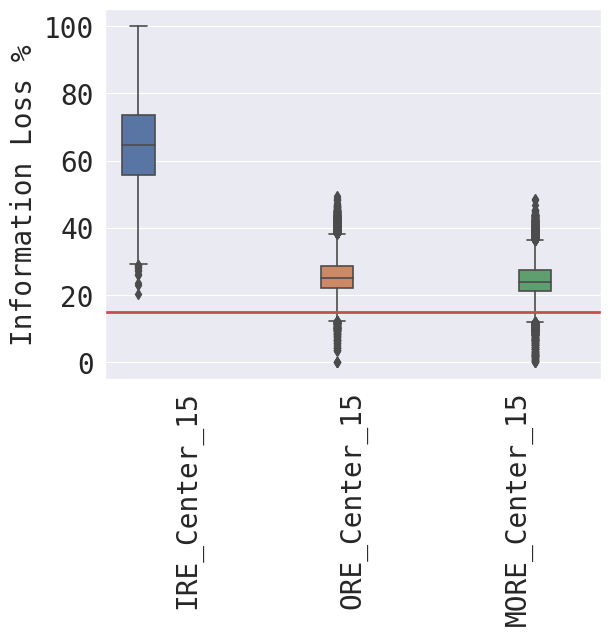

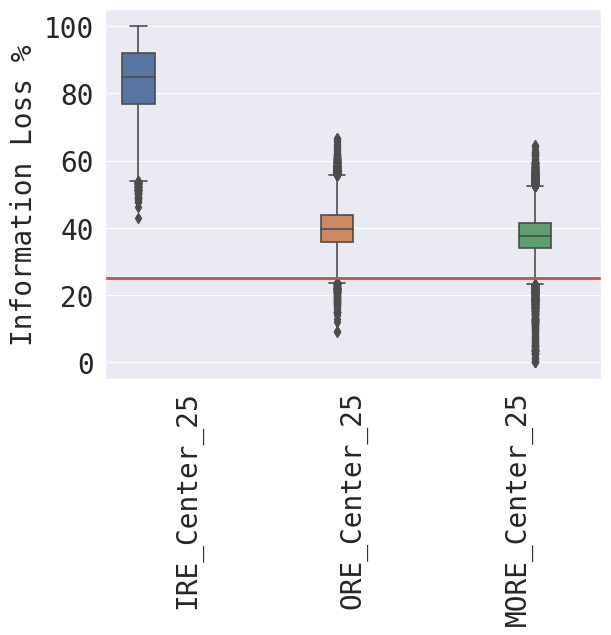

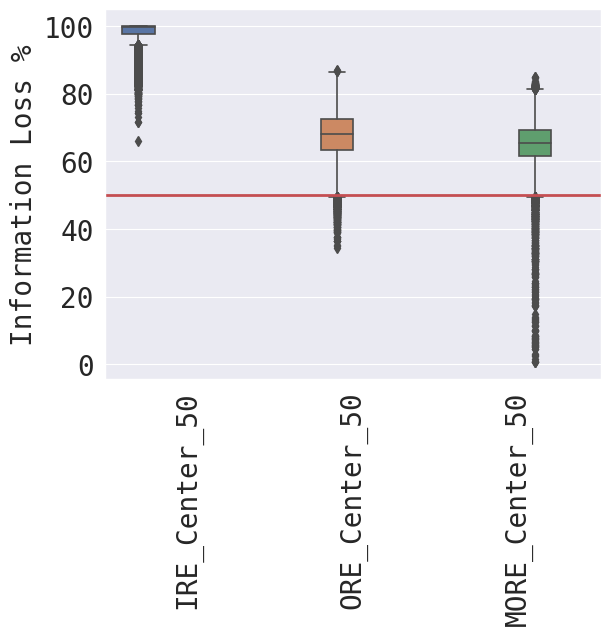

In [14]:
plot_center(df_center, 15)
plot_center(df_center, 25)
plot_center(df_center, 50)

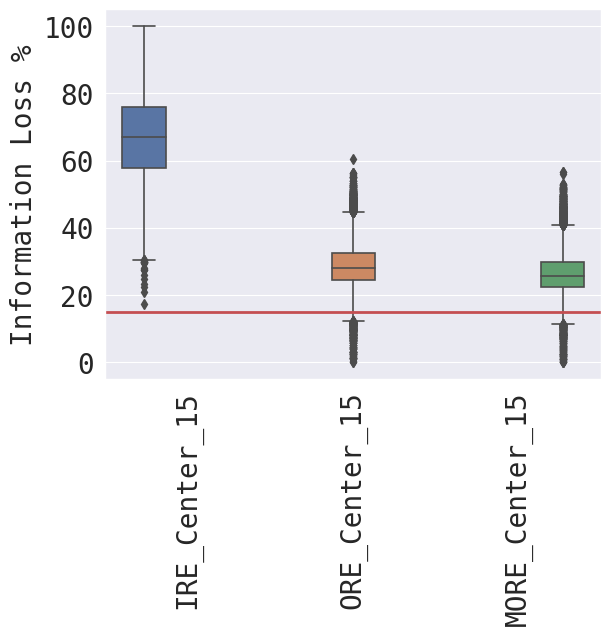

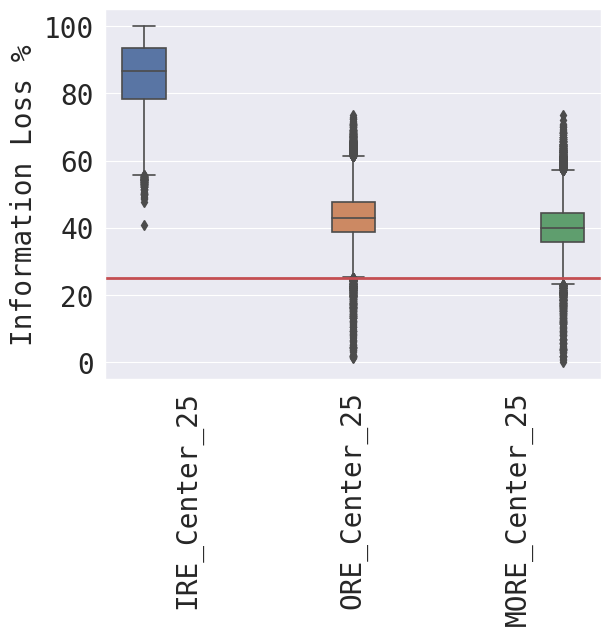

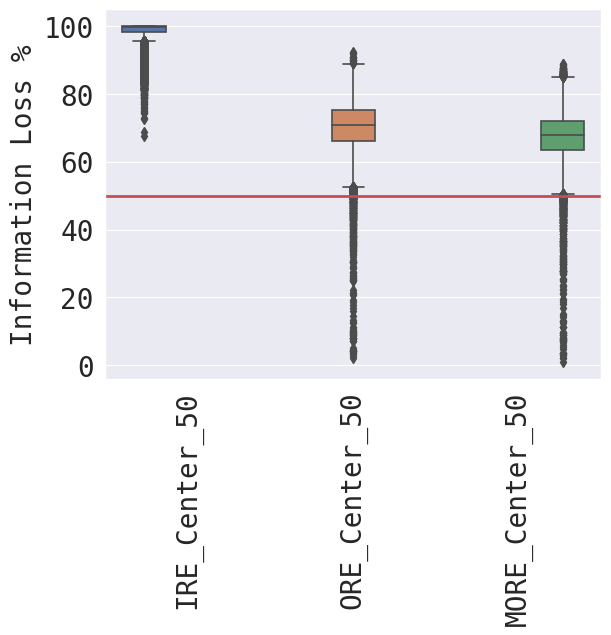

In [115]:
plot_center(df_center, 15)
plot_center(df_center, 25)
plot_center(df_center, 50)

In [ ]:
def plot_ire_ore(df_center, m_size):
    df_center_m = df_center[df_center["Mask size"]==m_size]
    
    sns.set(context="paper", font="monospace")

    fig, ax = plt.subplots(ncols=1)

    g = sns.boxplot(data=df_center_m, x="Dataset", y="Info loss %", palette="Paired", ax=ax)
    ax.axhline(m_size, 0, 1, linewidth=2, color="r") # https://stackoverflow.com/questions/52005576/seaborn-boxplot-horizontal-line-annotation

    g.set_xlabel("",fontsize=0)
    g.set_ylabel("Information Loss %",fontsize=20)
    g.tick_params(labelsize=20)
    plt.setp(g.get_xticklabels(), rotation=90)

df_ire_ore = df[((df['Mask position'] == "Center") | (df['Mask position'] == "Random")) & ((df["Mask bounding box"] == "IRE") | (df["Mask bounding box"] == "ORE"))]
df_ire_ore["Mask bounding box"] = pd.Categorical(df_ire_ore["Mask bounding box"], ["IRE", "ORE"])
df_ire_ore["Mask size"] = df_ire_ore["Mask size"].astype(int)
df_ire_ore = df_ire_ore.sort_values(["Mask size", "Mask bounding box"])


In [39]:
df_random = df[(df['Mask position'] == "Random")]
print(get_summary(df_random, 15, "IRE"))
print(get_summary(df_random, 25, "IRE"))
print(get_summary(df_random, 50, "IRE"))

count    32567.000000
mean        32.861775
std         18.777160
min         -0.000000
25%         18.559552
50%         30.631704
75%         45.364449
max         98.540146
Name: Info loss %, dtype: float64
count    32567.000000
mean        59.708764
std         17.871872
min         -0.000000
25%         46.683596
50%         59.420606
75%         72.867096
max        100.000000
Name: Info loss %, dtype: float64
count    32567.000000
mean        94.315100
std          6.491213
min         54.475948
25%         91.332580
50%         96.636260
75%         99.415480
max        100.000000
Name: Info loss %, dtype: float64


In [40]:
df_random = df[(df['Mask position'] == "Random")]
print(get_summary(df_random, 15, "ORE"))
print("IRE 25 \n",get_summary(df_random, 25, "ORE"))
print("IRE 50 \n",get_summary(df_random, 50, "ORE"))

count    32567.000000
mean        20.968067
std          8.790143
min         -0.000000
25%         15.438261
50%         21.723835
75%         26.772968
max         62.615101
Name: Info loss %, dtype: float64
IRE 25 
 count    32567.000000
mean        35.534479
std         10.891978
min         -0.000000
25%         29.377587
50%         36.403509
75%         42.686863
max         77.298311
Name: Info loss %, dtype: float64
IRE 50 
 count    32567.000000
mean        66.594652
std         10.615728
min          2.077151
25%         60.771340
50%         67.704403
75%         73.803303
max         95.108260
Name: Info loss %, dtype: float64


/tmp/ipykernel_7502/3109444017.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ire_ore["Mask bounding box"] = pd.Categorical(df_ire_ore["Mask bounding box"], ["IRE", "ORE"])
/tmp/ipykernel_7502/3109444017.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ire_ore["Mask size"] = df_ire_ore["Mask size"].astype(int)


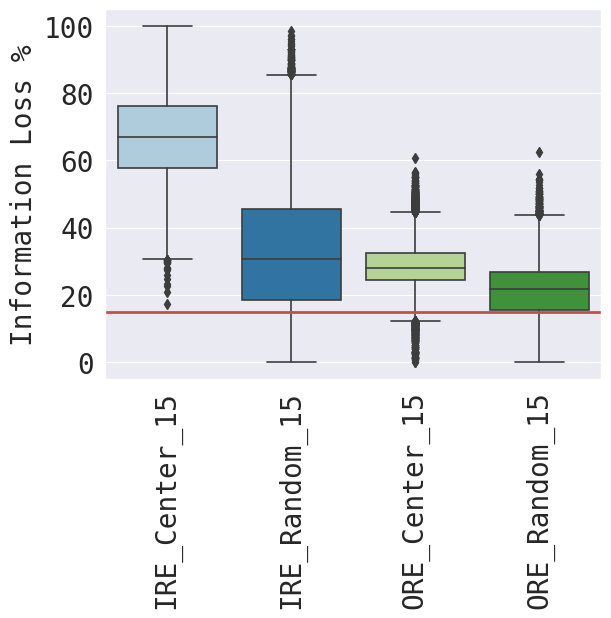

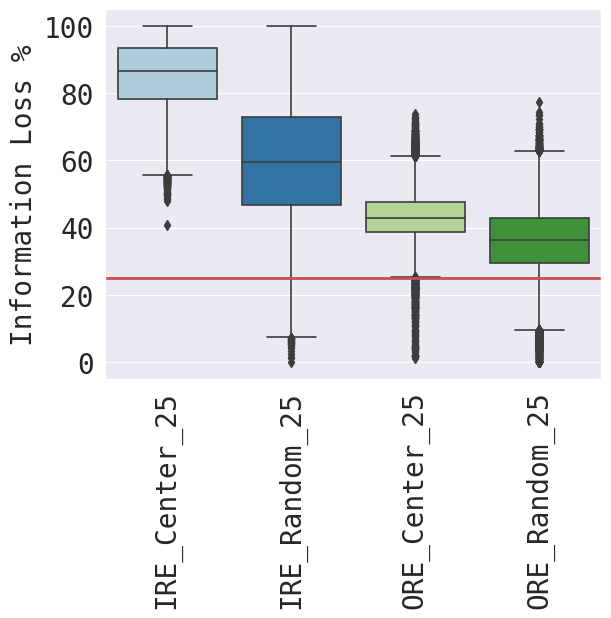

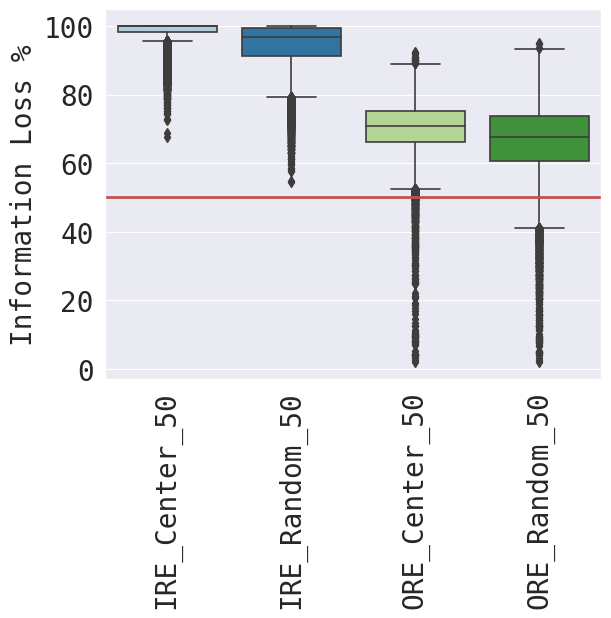

In [28]:
plot_ire_ore(df_ire_ore, 15)
plot_ire_ore(df_ire_ore, 25)
plot_ire_ore(df_ire_ore, 50)

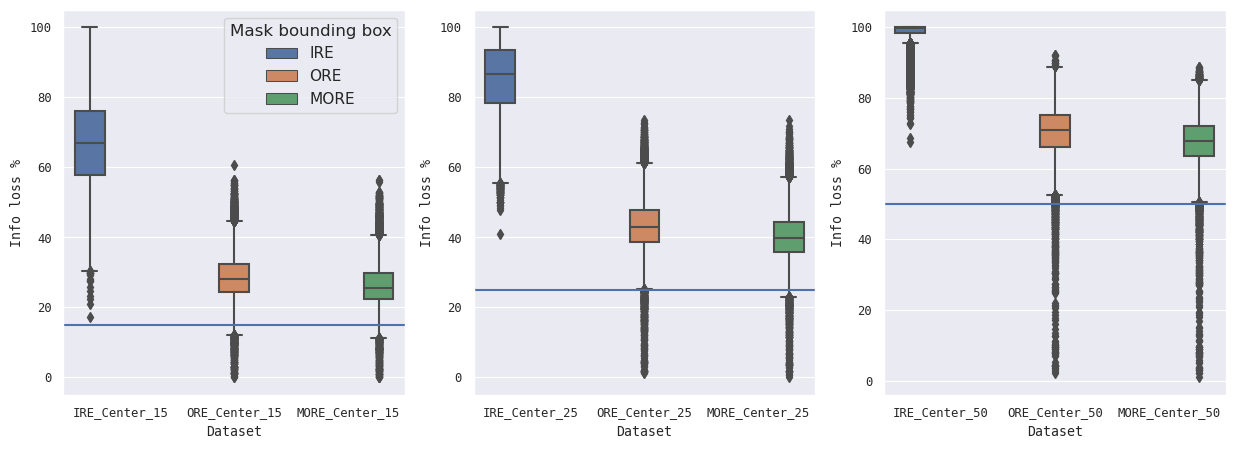

In [95]:
# https://stackoverflow.com/questions/52005576/seaborn-boxplot-horizontal-line-annotation

df_center_15 = df_center[df_center["Mask size"]==15]
df_center_25 = df_center[df_center["Mask size"]==25]
df_center_50 = df_center[df_center["Mask size"]==50]

fig, ax = plt.subplots(ncols=3,figsize=(15,5))

sns.set(font_scale=1)

a = sns.boxplot(data=df_center_15, x="Dataset", y="Info loss %", hue="Mask bounding box", ax=ax[0])
# plt.setp(a.get_xticklabels(), rotation=-45)
ax[0].axhline(15, 0, 1)
b = sns.boxplot(data=df_center_25, x="Dataset", y="Info loss %", hue="Mask bounding box", ax=ax[1])
# plt.setp(b.get_xticklabels(), rotation=-45)
ax[1].axhline(25, 0, 1)
ax[1].get_legend().remove()
c = sns.boxplot(data=df_center_50, x="Dataset", y="Info loss %", hue="Mask bounding box", ax=ax[2])
# plt.setp(c.get_xticklabels(), rotation=-45)
ax[2].axhline(50, 0, 1)
ax[2].get_legend().remove()
